# Importance of Feature Scaling
- 표준화를 통한 feature scaling은 많은 머신 러닝 알고리즘에서 중요

## Load and prepare data

In [1]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = load_wine(return_X_y=True, as_frame=True)
scaler = StandardScaler().set_output(transform="pandas")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)
scaled_X_train = scaler.fit_transform(X_train)

## Effect of rescaling on a k-neighbors models

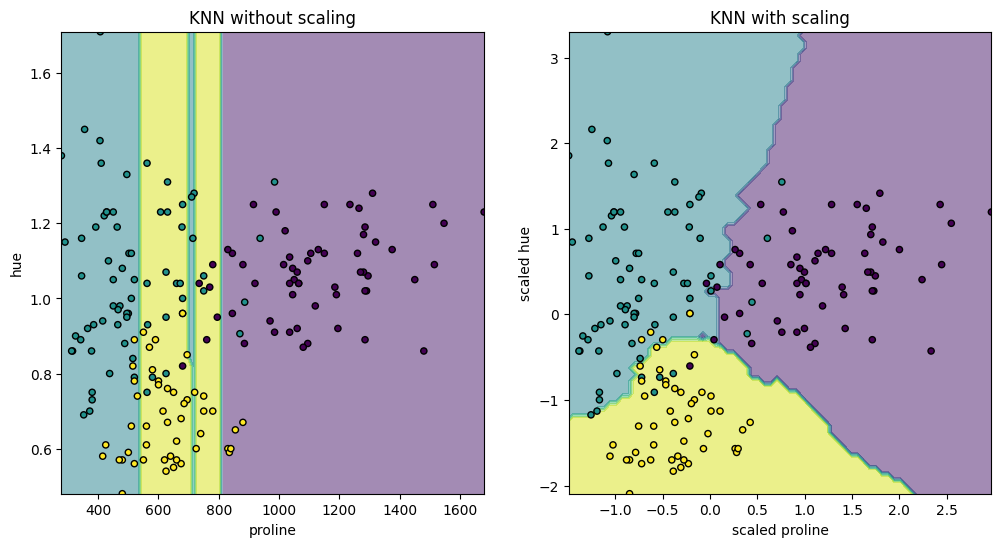

In [2]:
import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier

X_plot = X[["proline", "hue"]]
X_plot_scaled = scaler.fit_transform(X_plot)
clf = KNeighborsClassifier(n_neighbors=20)


def fit_and_plot_model(X_plot, y, clf, ax):
    clf.fit(X_plot, y)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_plot,
        response_method="predict",
        alpha=0.5,
        ax=ax,
    )
    disp.ax_.scatter(X_plot["proline"], X_plot["hue"], c=y, s=20, edgecolor="k")
    disp.ax_.set_xlim((X_plot["proline"].min(), X_plot["proline"].max()))
    disp.ax_.set_ylim((X_plot["hue"].min(), X_plot["hue"].max()))
    return disp.ax_


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

fit_and_plot_model(X_plot, y, clf, ax1)
ax1.set_title("KNN without scaling")

fit_and_plot_model(X_plot_scaled, y, clf, ax2)
ax2.set_xlabel("scaled proline")
ax2.set_ylabel("scaled hue")
_ = ax2.set_title("KNN with scaling")

## Effect of rescaling on a PCA dimensional reduction

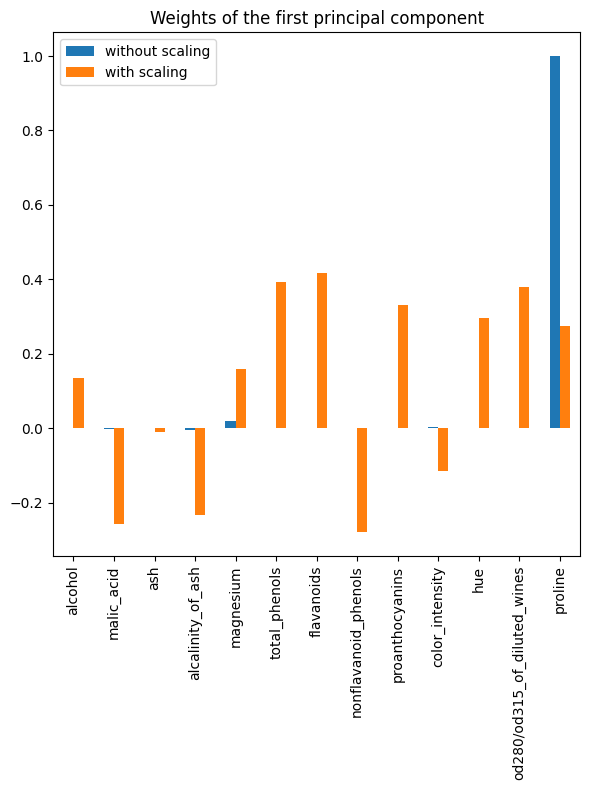

In [3]:
import pandas as pd

from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(X_train)
scaled_pca = PCA(n_components=2).fit(scaled_X_train)
X_train_transformed = pca.transform(X_train)
X_train_std_transformed = scaled_pca.transform(scaled_X_train)

first_pca_component = pd.DataFrame(
    pca.components_[0], index=X.columns, columns=["without scaling"]
)
first_pca_component["with scaling"] = scaled_pca.components_[0]
first_pca_component.plot.bar(
    title="Weights of the first principal component", figsize=(6, 8)
)

_ = plt.tight_layout()

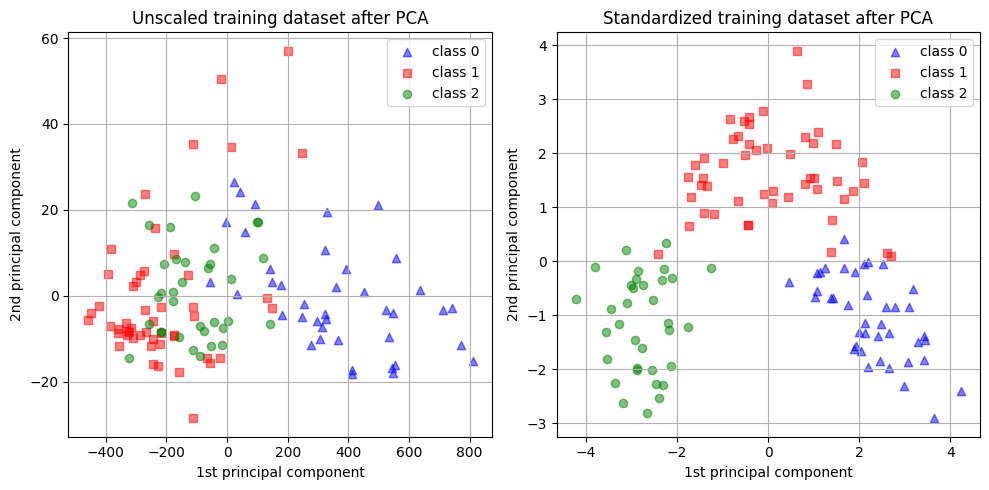

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

target_classes = range(0, 3)
colors = ("blue", "red", "green")
markers = ("^", "s", "o")

for target_class, color, marker in zip(target_classes, colors, markers):
    ax1.scatter(
        x=X_train_transformed[y_train == target_class, 0],
        y=X_train_transformed[y_train == target_class, 1],
        color=color,
        label=f"class {target_class}",
        alpha=0.5,
        marker=marker,
    )

    ax2.scatter(
        x=X_train_std_transformed[y_train == target_class, 0],
        y=X_train_std_transformed[y_train == target_class, 1],
        color=color,
        label=f"class {target_class}",
        alpha=0.5,
        marker=marker,
    )

ax1.set_title("Unscaled training dataset after PCA")
ax2.set_title("Standardized training dataset after PCA")

for ax in (ax1, ax2):
    ax.set_xlabel("1st principal component")
    ax.set_ylabel("2nd principal component")
    ax.legend(loc="upper right")
    ax.grid()

_ = plt.tight_layout()

## Effect of rescaling on models's performance

In [5]:
import numpy as np

from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline

Cs = np.logspace(-5, 5, 20)

unscaled_clf = make_pipeline(pca, LogisticRegressionCV(Cs=Cs))
unscaled_clf.fit(X_train, y_train)

scaled_clf = make_pipeline(scaler, pca, LogisticRegressionCV(Cs=Cs))
scaled_clf.fit(X_train, y_train)

print(f"Optimal C for the unscaled PCA: {unscaled_clf[-1].C_[0]:.4f}\n")
print(f"Optimal C for the standardized data with PCA: {scaled_clf[-1].C_[0]:.2f}")

Optimal C for the unscaled PCA: 0.0004

Optimal C for the standardized data with PCA: 20.69


In [6]:
from sklearn.metrics import accuracy_score, log_loss

y_pred = unscaled_clf.predict(X_test)
y_pred_scaled = scaled_clf.predict(X_test)
y_proba = unscaled_clf.predict_proba(X_test)
y_proba_scaled = scaled_clf.predict_proba(X_test)

print("Test accuracy for the unscaled PCA")
print(f"{accuracy_score(y_test, y_pred):.2%}\n")
print("Test accuracy for the standardized data with PCA")
print(f"{accuracy_score(y_test, y_pred_scaled):.2%}\n")
print("Log-loss for the unscaled PCA")
print(f"{log_loss(y_test, y_proba):.3}\n")
print("Log-loss for the standardized data with PCA")
print(f"{log_loss(y_test, y_proba_scaled):.3}")

Test accuracy for the unscaled PCA
35.19%

Test accuracy for the standardized data with PCA
96.30%

Log-loss for the unscaled PCA
2.07

Log-loss for the standardized data with PCA
0.0824
